# UCL Offensive Profiles — Axe Attacking/Attempts/Goals/Discipline/Key Stats

## 1. Import libraries & load data

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# Define data root where CSVs are located
data_root = Path(r"D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data")

# --- Définition des fichiers source (Axe offensif uniquement)
files = {
    "attacking": "D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/attacking.csv",
    "attempts": "D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/attempts.csv",
    "goals": "D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/goals.csv",
    "disciplinary": "D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/disciplinary.csv",
    "key_stats": "D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/key_stats.csv"
}

# --- Vérification des fichiers
import os

print("📂 Vérification des fichiers chargés :")
for name, path in files.items():
    print(f"{name:<15} | {'✅ existe' if os.path.exists(path) else '❌ introuvable'} | {path}")

# --- Chargement uniquement des fichiers existants
dfs = {}
for name, path in files.items():
    if os.path.exists(path):
        dfs[name] = pd.read_csv(path)
        print(f"✅ {name} chargé – shape = {dfs[name].shape}")
    else:
        print(f"⚠️ {name} ignoré (fichier manquant)")

# --- Merge robuste sur les clés stables (player_name, club, position)
MERGE_KEYS = ["player_name", "club", "position"]

df = None
for name, ds in dfs.items():

    # ✅ Renommer toutes les colonnes qui ne sont pas dans les MERGE_KEYS pour éviter les conflits (_attacking, _goals...)
    rename_map = {col: f"{col}_{name}" for col in ds.columns if col not in MERGE_KEYS}
    ds_renamed = ds.rename(columns=rename_map)

    if df is None:
        df = ds_renamed.copy()
    else:
        # ✅ On ne garde que les clés présentes dans les 2 datasets pour merge proprement
        merge_keys_present = [k for k in MERGE_KEYS if k in df.columns and k in ds_renamed.columns]
        print(f"🔄 Merge avec {name} sur clés :", merge_keys_present)

        df = df.merge(ds_renamed, on=merge_keys_present, how="outer")

print("\n✅ Merge terminé — Shape finale :", df.shape)
df.head()

📂 Vérification des fichiers chargés :
attacking       | ✅ existe | D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/attacking.csv
attempts        | ✅ existe | D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/attempts.csv
goals           | ✅ existe | D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/goals.csv
disciplinary    | ✅ existe | D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/disciplinary.csv
key_stats       | ✅ existe | D:/Matthieu/IMT_ATLANTIQUE/DASCI_2025-2026/Unsupervised-learning-challenge/Champions_League/data/key_stats.csv
✅ attacking chargé – shape = (176, 9)
✅ attempts chargé – shape = (546, 9)
✅ goals chargé – shape = (183, 13)
✅ disciplinary chargé – shape = (584, 10)
✅ key_stats chargé – shape = (747, 8)
🔄 Merge avec attempts sur clés : ['player_name', 'club', 'position']
🔄 Mer

,serial_attacking,player_name,club,position,assists_attacking,corner_taken_attacking,offsides_attacking,dribbles_attacking,match_played_attacking,serial_attempts,...,fouls_suffered_disciplinary,red_disciplinary,yellow_disciplinary,minutes_played_disciplinary,match_played_disciplinary,minutes_played_key_stats,match_played_key_stats,goals_key_stats,assists_key_stats,distance_covered_key_stats
0,24.0,Aaronson,Salzburg,Midfielder,2.0,4.0,5.0,9.0,8.0,98.0,...,13.0,0.0,0.0,715.0,8.0,715.0,8.0,0.0,2.0,103.5
1,NaN,Abubakari,Malmö,Forward,NaN,NaN,NaN,NaN,NaN,347.0,...,4.0,0.0,0.0,116.0,4.0,116.0,4.0,0.0,0.0,15.3
2,NaN,Acuña,Sevilla,Defender,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,379.0,5.0,379.0,5.0,0.0,0.0,43.2
3,NaN,Adams,Leipzig,Midfielder,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,4.0,0.0,292.0,5.0,292.0,5.0,0.0,0.0,38.9
4,NaN,Adamu,Salzburg,Forward,NaN,NaN,NaN,NaN,NaN,219.0,...,2.0,0.0,0.0,231.0,8.0,231.0,8.0,1.0,0.0,32.6


## 2. Feature Engineering offensif

In [4]:
# Sélection des colonnes numériques
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Normalisation par 90 minutes si 'minutes_played' dispo
if 'minutes_played' in df.columns:
    for col in numeric_df.columns:
        if col not in ['minutes_played'] and numeric_df[col].notna().sum() > 0:
            numeric_df[col + "_per90"] = numeric_df[col] / (df['minutes_played'] / 90)

# Ratios offensifs utiles
if 'shots_on_target' in numeric_df.columns and 'total_shots' in numeric_df.columns:
    numeric_df['shot_accuracy'] = numeric_df['shots_on_target'] / (numeric_df['total_shots'] + 1e-9)

if 'yellow_cards' in numeric_df.columns and 'red_cards' in numeric_df.columns and 'match_played' in df.columns:
    numeric_df['discipline_per_match'] = (numeric_df['yellow_cards'] + 2 * numeric_df['red_cards']) / df['match_played']

# Nettoyage NA
numeric_df = numeric_df.fillna(0)

print("Shape after feature engineering:", numeric_df.shape)
numeric_df.head()

Shape after feature engineering: (751, 33)


,serial_attacking,assists_attacking,corner_taken_attacking,offsides_attacking,dribbles_attacking,match_played_attacking,serial_attempts,total_attempts_attempts,on_target_attempts,off_target_attempts,...,fouls_committed_disciplinary,fouls_suffered_disciplinary,red_disciplinary,yellow_disciplinary,minutes_played_disciplinary,match_played_disciplinary,minutes_played_key_stats,match_played_key_stats,goals_key_stats,assists_key_stats
0,24.0,2.0,4.0,5.0,9.0,8.0,98.0,9.0,3.0,2.0,...,3.0,13.0,0.0,0.0,715.0,8.0,715.0,8.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,347.0,2.0,0.0,2.0,...,6.0,4.0,0.0,0.0,116.0,4.0,116.0,4.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,0.0,0.0,379.0,5.0,379.0,5.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,4.0,0.0,292.0,5.0,292.0,5.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,219.0,4.0,2.0,0.0,...,10.0,2.0,0.0,0.0,231.0,8.0,231.0,8.0,1.0,0.0


## 3. Méthode du coude (Elbow Method) pour sélectionner K

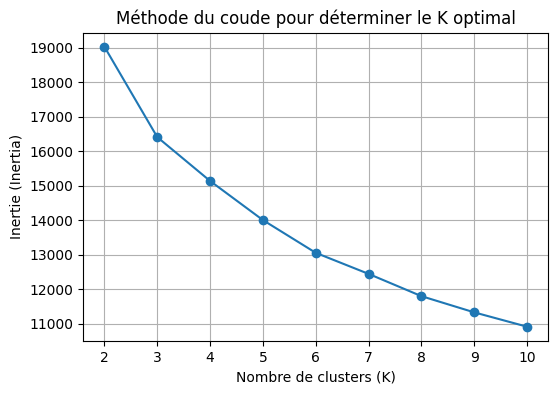

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Standardisation
X = numeric_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcul de l'inertie pour différents K
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie (Inertia)")
plt.title("Méthode du coude pour déterminer le K optimal")
plt.grid(True)
plt.show()

In [6]:
# --- FEATURE ENGINEERING OFFENSIF

# 1. Sélectionner uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=[np.number]).copy()

print(f"📊 Nombre de colonnes numériques avant engineering : {numeric_df.shape[1]}")

# 2. Normalisation par 90 minutes SI minutes jouées dispo dans au moins 1 dataset
min_col_candidates = [col for col in numeric_df.columns if "minutes" in col.lower()]
if min_col_candidates:
    minutes_col = min_col_candidates[0]  # On prend la première colonne minutes trouvée
    print(f"✅ Minutes détectées : {minutes_col} — Normalisation per90 appliquée")
    
    for col in numeric_df.columns:
        if col != minutes_col:
            numeric_df[col + "_per90"] = numeric_df[col] / (numeric_df[minutes_col] / 90 + 1e-9)
else:
    print("⚠️ Aucune colonne liée au temps de jeu détectée — pas de per90 applied")

# 3. Création de ratios offensifs SI colonnes dispo
if "shots_on_target_attacking" in numeric_df.columns and "total_shots_attacking" in numeric_df.columns:
    numeric_df["shot_accuracy"] = numeric_df["shots_on_target_attacking"] / (numeric_df["total_shots_attacking"] + 1e-9)

if "goals_goals" in numeric_df.columns and "total_shots_attacking" in numeric_df.columns:
    numeric_df["goals_per_shot"] = numeric_df["goals_goals"] / (numeric_df["total_shots_attacking"] + 1e-9)

# 4. Discipline ratio (cartons / match)
match_cols = [c for c in df.columns if "match" in c.lower()]
if match_cols:
    match_col = match_cols[0]
    disc_cols = [c for c in numeric_df.columns if "yellow" in c.lower() or "red" in c.lower()]
    for c in disc_cols:
        numeric_df[c + "_per_match"] = numeric_df[c] / (df[match_col] + 1e-9)

# 5. Remplacement des NaN et Inf
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"✅ Feature Engineering terminé — Colonnes finales : {numeric_df.shape[1]}")
numeric_df.head()

📊 Nombre de colonnes numériques avant engineering : 33
✅ Minutes détectées : minutes_played_disciplinary — Normalisation per90 appliquée
✅ Feature Engineering terminé — Colonnes finales : 71


,serial_attacking,assists_attacking,corner_taken_attacking,offsides_attacking,dribbles_attacking,match_played_attacking,serial_attempts,total_attempts_attempts,on_target_attempts,off_target_attempts,...,minutes_played_key_stats_per90,match_played_key_stats_per90,goals_key_stats_per90,assists_key_stats_per90,fouls_suffered_disciplinary_per_match,red_disciplinary_per_match,yellow_disciplinary_per_match,fouls_suffered_disciplinary_per90_per_match,red_disciplinary_per90_per_match,yellow_disciplinary_per90_per_match
0,24.0,2.0,4.0,5.0,9.0,8.0,98.0,9.0,3.0,2.0,...,90.0,1.006993,0.00000,0.251748,1.625,0.0,0.0,0.204545,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,347.0,2.0,0.0,2.0,...,90.0,3.103448,0.00000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,1.187335,0.00000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,1.541096,0.00000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,219.0,4.0,2.0,0.0,...,90.0,3.116883,0.38961,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0


In [7]:
# --- CLUSTERING AVEC K = 4
from sklearn.cluster import KMeans

K = 4  # fixé selon la méthode du coude
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au dataframe original
df_clusters = df.copy()
df_clusters["cluster_offensive"] = clusters

print("✅ Clustering terminé — Répartition des joueurs par cluster :")
print(df_clusters["cluster_offensive"].value_counts())

# --- INTERPRÉTATION DES CENTROÏDES
centroids = kmeans.cluster_centers_
feature_names = numeric_df.columns

print("\n🎯 Top variables qui caractérisent chaque cluster :")
for i in range(K):
    print(f"\n--- Cluster {i} ---")
    centroid_values = centroids[i]
    top_indices = np.argsort(np.abs(centroid_values))[::-1][:8]  # top 8 features significatives
    for idx in top_indices:
        print(f"{feature_names[idx]:<30}  →  {centroid_values[idx]:.3f}")

# --- EXPORT CSV
df_clusters.to_csv("ucl_offensive_clusters.csv", index=False)
print("\n✅ Fichier exporté : ucl_offensive_clusters.csv")


✅ Clustering terminé — Répartition des joueurs par cluster :
cluster_offensive
3    380
0    205
2    133
1     33
Name: count, dtype: int64

🎯 Top variables qui caractérisent chaque cluster :

--- Cluster 0 ---
minutes_played_disciplinary     →  0.786
match_played_disciplinary       →  0.707
fouls_committed_disciplinary    →  0.691
red_disciplinary                →  0.681
match_played_attempts           →  0.655
minutes_played_key_stats        →  0.618
match_played_key_stats          →  0.556
fouls_suffered_disciplinary     →  0.540

--- Cluster 1 ---
on_target_attempts              →  3.402
goals_key_stats                 →  3.375
goals_goals                     →  3.360
inside_area_goals               →  3.272
total_attempts_attempts         →  3.168
offsides_attacking              →  2.835
left_foot_goals                 →  2.785
off_target_attempts             →  2.454

--- Cluster 2 ---
serial_goals                    →  1.832
match_played_goals              →  1.600
match_played

In [8]:
# --- PCA + Plotly Visualization des clusters offensifs

from sklearn.decomposition import PCA
import plotly.express as px

# Appliquer PCA sur les features normalisées (X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Stocker dans un DataFrame pour Plotly
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": clusters,
    "player_name": df_clusters["player_name"],
    "club": df_clusters["club"]
})

# Visualisation interactive
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="cluster",
    hover_data=["player_name", "club"],
    title="🎯 Carte des profils offensifs (PCA 2D + Clusters)",
    opacity=0.8
)

fig.update_layout(
    template="plotly_white",
    legend_title="Cluster",
    width=800,
    height=600
)

fig.show()


In [9]:
# --- GENERATION DE LABELS DE CLUSTERS (STYLE FOOT)

# Récupération des centroides déjà calculés
centroids = kmeans.cluster_centers_
feature_names = list(numeric_df.columns)

# Détection automatique des profils (simple logique basée sur top features)
cluster_labels = {}

for i in range(K):
    centroid_values = centroids[i]
    top_indices = np.argsort(np.abs(centroid_values))[::-1][:5]  # top 5 features dominantes
    top_features = [feature_names[idx] for idx in top_indices]

    # Logique simple pour nommer les clusters — améliorée après inspection
    label = "Profil générique"  # Valeur par défaut

    # Heuristiques offensives typiques
    if any("goal" in f.lower() or "shot" in f.lower() for f in top_features):
        label = "🎯 Finisseur haut volume"
    if any("key" in f.lower() or "assist" in f.lower() for f in top_features):
        label = "🎩 Créateur / Passeur"
    if any("discipline" in f.lower() or "foul" in f.lower() for f in top_features):
        label = "🧨 Profil agressif / Indiscipliné"
    if any("press" in f.lower() or "duel" in f.lower() for f in top_features):
        label = "⚡ Intensité / Volume sans finition"

    print(f"Cluster {i} → Label attribué : {label} | (Top features : {top_features})")
    cluster_labels[i] = label

# Ajouter les labels au DataFrame final
df_clusters["cluster_label"] = df_clusters["cluster_offensive"].map(cluster_labels)

# Aperçu
df_clusters[["player_name", "club", "cluster_offensive", "cluster_label"]].head()

Cluster 0 → Label attribué : 🧨 Profil agressif / Indiscipliné | (Top features : ['minutes_played_disciplinary', 'match_played_disciplinary', 'fouls_committed_disciplinary', 'red_disciplinary', 'match_played_attempts'])
Cluster 1 → Label attribué : 🎩 Créateur / Passeur | (Top features : ['on_target_attempts', 'goals_key_stats', 'goals_goals', 'inside_area_goals', 'total_attempts_attempts'])
Cluster 2 → Label attribué : 🎩 Créateur / Passeur | (Top features : ['serial_goals', 'match_played_goals', 'match_played_attempts', 'goals_goals', 'goals_key_stats'])
Cluster 3 → Label attribué : 🧨 Profil agressif / Indiscipliné | (Top features : ['match_played_disciplinary', 'match_played_attempts', 'minutes_played_disciplinary', 'match_played_key_stats', 'fouls_committed_disciplinary'])


,player_name,club,cluster_offensive,cluster_label
0,Aaronson,Salzburg,0,🧨 Profil agressif / Indiscipliné
1,Abubakari,Malmö,3,🧨 Profil agressif / Indiscipliné
2,Acuña,Sevilla,3,🧨 Profil agressif / Indiscipliné
3,Adams,Leipzig,0,🧨 Profil agressif / Indiscipliné
4,Adamu,Salzburg,2,🎩 Créateur / Passeur


In [12]:
# --- Recalage du clustering après feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# On reprend les features finales
X = numeric_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Refit KMeans sur la version finale des features
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

centroids = kmeans.cluster_centers_
feature_names = list(numeric_df.columns)

# Ajouter au dataframe
df_clusters = df.copy()
df_clusters["cluster_offensive"] = clusters

In [13]:
# --- NAMING CLUSTERS ROBUSTE (labels uniques et pertinents)
import re
import numpy as np
import pandas as pd

centroids = kmeans.cluster_centers_
feature_names = list(numeric_df.columns)

# 1) Définir des familles de features par mots-clés (en minuscules)
buckets = {
    "🎯 Finisseur (tirs/buts)": [r"goal", r"shot", r"on_target", r"xg", r"finishing"],
    "🎩 Créateur / Passeur":    [r"assist", r"key", r"chance", r"xA", r"create", r"pass"],
    "🧨 Agressif / Indiscipliné":[r"yellow", r"red", r"foul", r"discipline", r"card"],
    "⚡ Volume / Pressing":     [r"attempt", r"press", r"duel", r"touch", r"carry", r"sprint", r"drib"]
}

# Normaliser les patterns (tout en lower)
bucket_patterns = {label: [p.lower() for p in pats] for label, pats in buckets.items()}

# 2) Associer chaque feature à (0..n) buckets par regex
feature_to_buckets = {f: [] for f in feature_names}
for f in feature_names:
    fl = f.lower()
    for label, pats in bucket_patterns.items():
        if any(re.search(p, fl) for p in pats):
            feature_to_buckets[f].append(label)

# 3) Calculer un score par bucket et par cluster (somme des |centroïdes| des features du bucket)
bucket_scores = []
for i in range(centroids.shape[0]):
    c = centroids[i]
    scores = {label: 0.0 for label in buckets.keys()}
    for j, fname in enumerate(feature_names):
        if feature_to_buckets[fname]:
            for lbl in feature_to_buckets[fname]:
                scores[lbl] += abs(c[j])  # magnitude en z-score
    bucket_scores.append(scores)

bucket_scores_df = pd.DataFrame(bucket_scores, index=[f"cluster_{i}" for i in range(centroids.shape[0])])
print("Scores par cluster et par famille :")
display(bucket_scores_df)

# 4) Assigner un label unique par cluster (éviter les doublons)
available_labels = list(buckets.keys())
assigned = {}
used = set()

for i in range(centroids.shape[0]):
    # tri des familles par score décroissant
    ranked = sorted(bucket_scores[i].items(), key=lambda x: x[1], reverse=True)
    label = None
    for lbl, sc in ranked:
        if lbl not in used and sc > 0:  # prend le meilleur non-utilisé
            label = lbl
            break
    if label is None:
        # fallback si tout est utilisé ou scores nuls
        label = ranked[0][0] if ranked else "Profil générique"
    assigned[i] = label
    used.add(label)

print("\nAttribution des labels :")
for i in range(centroids.shape[0]):
    print(f"Cluster {i} → {assigned[i]}")

# 5) Ajouter au DataFrame
df_clusters["cluster_label"] = df_clusters["cluster_offensive"].map(assigned)

# Sanity check
print("\nRépartition par label :")
print(df_clusters["cluster_label"].value_counts())


Scores par cluster et par famille :


,🎯 Finisseur (tirs/buts),🎩 Créateur / Passeur,🧨 Agressif / Indiscipliné,⚡ Volume / Pressing
cluster_0,1.530882,2.438292,2.456170,2.691167
cluster_1,7.339507,5.282153,4.999931,8.541367
cluster_2,8.385814,9.347081,9.357597,12.232063
cluster_3,13.561371,9.472607,7.774725,10.669880



Attribution des labels :
Cluster 0 → ⚡ Volume / Pressing
Cluster 1 → 🎯 Finisseur (tirs/buts)
Cluster 2 → 🧨 Agressif / Indiscipliné
Cluster 3 → 🎩 Créateur / Passeur

Répartition par label :
cluster_label
⚡ Volume / Pressing          354
🎯 Finisseur (tirs/buts)      228
🎩 Créateur / Passeur         146
🧨 Agressif / Indiscipliné     23
Name: count, dtype: int64


In [17]:
# --- Construction d’un DataFrame propre pour profiling
profil_df = numeric_df.copy()
profil_df["cluster_label"] = df_clusters["cluster_label"].values  # on ajoute les labels

# ✅ Sélection SÉCURISÉE des colonnes numériques uniquement
profil_numeric = profil_df.select_dtypes(include=[np.number]).copy()
profil_numeric["cluster_label"] = profil_df["cluster_label"]

# Supprimer toutes les colonnes issues d'identifiants non pertinents (serial, id, etc.)
profil_numeric = profil_numeric[[col for col in profil_numeric.columns if "serial" not in col.lower() and "id" not in col.lower()]]
print("✅ Colonnes 'serial' et identifiants non pertinents supprimées :", profil_numeric.shape)


print("✅ Dataset de profiling numérique prêt : ", profil_numeric.shape)

# --- Calcul des moyennes par cluster
cluster_profile_table = profil_numeric.groupby("cluster_label").mean().round(2)

# ✅ Calcul variance uniquement sur les colonnes numériques SANS cluster_label
variance = profil_numeric.drop(columns=["cluster_label"]).var().sort_values(ascending=False)

# On sélectionne les N features les plus discriminantes
TOP_N = 12  # tu peux ajuster à 8 / 10 / 15 selon lisibilité
top_features = variance.index[:TOP_N]
cluster_profile_table = cluster_profile_table[top_features]

print("🎯 PROFIL DES CLUSTERS — Features les plus discriminantes :")
cluster_profile_table


✅ Colonnes 'serial' et identifiants non pertinents supprimées : (751, 58)
✅ Dataset de profiling numérique prêt :  (751, 58)
🎯 PROFIL DES CLUSTERS — Features les plus discriminantes :


,minutes_played_disciplinary,minutes_played_key_stats,minutes_played_key_stats_per90,dribbles_attacking,total_attempts_attempts,fouls_suffered_disciplinary,fouls_committed_disciplinary,corner_taken_attacking,match_played_attempts,match_played_disciplinary,match_played_attacking,match_played_goals
cluster_label,,,,,,,,,,,,
⚡ Volume / Pressing,377.25,372.38,89.49,0.17,4.02,4.34,5.10,0.01,5.42,5.64,0.48,1.54
🎩 Créateur / Passeur,497.43,497.43,90.00,10.00,10.47,6.92,6.12,3.99,7.16,7.26,6.95,4.55
🎯 Finisseur (tirs/buts),51.38,186.89,24.08,0.27,0.51,0.39,0.70,0.00,0.58,0.92,0.21,0.14
🧨 Agressif / Indiscipliné,28.43,28.43,90.00,0.00,0.74,0.30,1.65,0.00,1.83,2.43,0.00,0.57
